### Binary Complete Neural Network

This notebook was created to test the conception of Binary Complete Convolution Networks and compare it with fully-precision networks and other approaches used in Binary Neural Networks

Importing all needed libraries

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import torch

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, lr_scheduler
from torch.amp import autocast, GradScaler
from datasets import load_dataset
from torchsummary import summary
from tqdm import tqdm
from src.models import ImageClassifier

/home/denis/Coding/projects/DiscreteNeuralNetworks/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Specifying CUDA if possible and setting multiprocessing start method to 'spawn', instead of 'fork', as it works better on UNIX-systems

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.multiprocessing.set_start_method('spawn', force=True)

Loading cifar10 dataset

In [3]:
cifar_ds = load_dataset('uoft-cs/cifar10')
cifar_train = cifar_ds['train']
cifar_test = cifar_ds['test']
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Checking samples

0
airplane


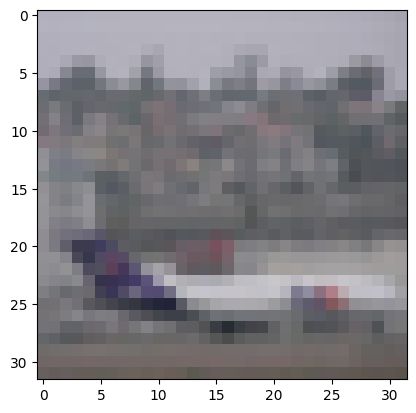

6
frog


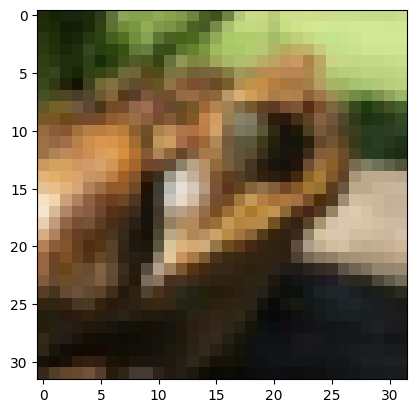

0
airplane


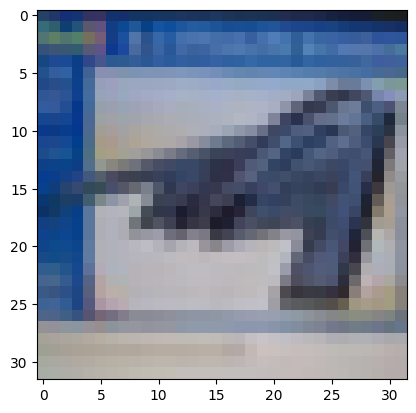

In [4]:
for i in range(3):
    sample = cifar_train[i]
    image = sample['img']
    label = sample['label']
    print(label)
    fig, ax = plt.subplots()
    print(class_names[label])
    #print(np.array(image))
    ax.imshow(image)
    plt.show()

Creating cifar10 dataset, no augmentation is used for better comparison

In [5]:
class Cifar10Dataset(Dataset):
    def __init__(self, dataset : Dataset, class_names : list[str] = None):
        super().__init__()
        self.dataset = dataset
        self.class_names = class_names

    def get_labeled(self, index : int):
        image, label = self.__getitem__(index)
        class_name = self.class_names[label]
        return image, class_name

    def __getitem__(self, index : int):
        sample = self.dataset[index]
        image = np.array(sample['img'])
        label = sample['label']
        return image, label

    def __len__(self):
        return len(self.dataset)

In [6]:
cifar_train_ds = Cifar10Dataset(cifar_train)
cifar_test_ds = Cifar10Dataset(cifar_test)

Creating simple dataloader

In [7]:
BATCH_SIZE = 8

def collate_fn(batch):
    images = []
    labels = []
    for image, label in batch:
        image = torch.Tensor(image).permute(2, 0, 1) # conv expects image as [channel, height, width] tensor
        images.append(image/255) # adding normalized image
        labels.append(label)
    images = torch.stack(images, dim=0).float()
    labels = torch.Tensor(labels).long()
    return images, labels

cifar_train_dataloader = DataLoader(cifar_train_ds, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
cifar_test_dataloader = DataLoader(cifar_test_ds, collate_fn=collate_fn, batch_size=BATCH_SIZE, pin_memory=True)

In [8]:
for i, (images, labels) in enumerate(cifar_train_dataloader):
    print(images)
    print(labels)
    break


tensor([[[[0.4078, 0.4275, 0.3686,  ..., 0.3176, 0.3333, 0.4275],
          [0.3882, 0.3804, 0.3529,  ..., 0.3686, 0.3529, 0.3882],
          [0.3608, 0.3569, 0.3647,  ..., 0.3412, 0.3294, 0.3608],
          ...,
          [0.4510, 0.4667, 0.4824,  ..., 0.8549, 0.8549, 0.8510],
          [0.4902, 0.5020, 0.4980,  ..., 0.8863, 0.8784, 0.8824],
          [0.5294, 0.5216, 0.5294,  ..., 0.8941, 0.8902, 0.9098]],

         [[0.4039, 0.4510, 0.3843,  ..., 0.3843, 0.4235, 0.5333],
          [0.4078, 0.4078, 0.3647,  ..., 0.4314, 0.4471, 0.5020],
          [0.4000, 0.3882, 0.3765,  ..., 0.4157, 0.4275, 0.4745],
          ...,
          [0.5569, 0.5569, 0.5686,  ..., 0.8196, 0.8196, 0.8235],
          [0.5804, 0.5843, 0.5804,  ..., 0.8431, 0.8392, 0.8549],
          [0.6078, 0.6000, 0.6118,  ..., 0.8549, 0.8510, 0.8745]],

         [[0.2863, 0.2745, 0.2431,  ..., 0.1020, 0.0745, 0.1686],
          [0.2588, 0.2431, 0.2157,  ..., 0.1882, 0.1098, 0.1216],
          [0.2196, 0.2314, 0.2235,  ..., 0

Specifying loss

In [9]:
loss_fn = nn.CrossEntropyLoss()

Specifying Zhegalkin model

In [10]:
model = ImageClassifier((3, 32, 32), 20, len(class_names)).to(device)

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              GELU-1            [-1, 5, 39, 39]               0
   ConvAttention2d-2            [-1, 5, 39, 39]               0
         LayerNorm-3            [-1, 5, 39, 39]           3,042
              GELU-4           [-1, 10, 46, 46]               0
   ConvAttention2d-5           [-1, 10, 46, 46]               0
         LayerNorm-6           [-1, 10, 46, 46]           4,232
              GELU-7           [-1, 20, 53, 53]               0
   ConvAttention2d-8           [-1, 20, 53, 53]               0
         LayerNorm-9           [-1, 20, 53, 53]           5,618
             GELU-10           [-1, 20, 60, 60]               0
  ConvAttention2d-11           [-1, 20, 60, 60]               0
        LayerNorm-12           [-1, 20, 60, 60]           7,200
             GELU-13           [-1, 20, 67, 67]               0
  ConvAttention2d-14           [-1, 20,

In [11]:
history = {
    "train_loss" : [float('inf')],
    "test_loss" : [float('inf')],
}

In [12]:
def compute_accuracy(predictions: torch.Tensor, ground_truth: torch.Tensor) -> float:
    """
    Вычисляет точность предсказаний модели на CIFAR-10.

    Аргументы:
        predictions (torch.Tensor): Логиты сети (без softmax), размер [batch_size, num_classes].
        ground_truth (torch.Tensor): Истинные метки, размер [batch_size].

    Возвращает:
        float: Значение точности (accuracy) в процентах.
    """
    predicted_classes = predictions.argmax(dim=1)
    correct = (predicted_classes == ground_truth).sum().item()
    accuracy = correct / ground_truth.size(0)
    return accuracy

In [13]:
def train(model, dataloader, optimizer, scheduler = None, accumulation_steps : int = 32):
    model.train()
    pbar = tqdm(dataloader, f"Train loss: {history['train_loss'][-1]:.3f}")
    total_loss = 0
    out_of_mem = 0
    acc_batch = []
    for batch_idx, (images, labels) in enumerate(pbar):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        try:
            prediction = model(images)
            loss_value = loss_fn(prediction, labels)
            loss_value.backward()

            if (batch_idx+1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            with torch.no_grad():
                acc_batch.append(compute_accuracy(prediction, labels))

            total_loss += loss_value.item()
            if batch_idx % 10 == 0:
                history['train_loss'].append(loss_value.item())
                pbar.set_description(f"Train loss: {history['train_loss'][-1]:.3f}")

        except RuntimeError as e:
            if 'out of memory' in str(e):
                out_of_mem += 1
                torch.cuda.empty_cache()
            else:
                raise e

        del images, labels
    if scheduler:
        scheduler.step(loss_value)
    if out_of_mem:
        print(f"Memory overflow occurred in {out_of_mem}/{batch_idx+1} batches")
    return total_loss/(batch_idx+1), sum(acc_batch)/len(acc_batch)

def test(model, dataloader):
    model.eval()
    pbar = tqdm(dataloader, f"Test loss: {history['test_loss'][-1]:.3f}")
    total_loss = 0
    out_of_mem = 0
    acc_batch = []
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(pbar):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            try:
                prediction = model(images)
                acc_batch.append(compute_accuracy(prediction, labels))
                loss_value = loss_fn(prediction, labels)

            except RuntimeError as e:
                if 'out of memory' in str(e):
                    out_of_mem += 1
                    torch.cuda.empty_cache()
                else:
                    raise e

            total_loss += loss_value.item()
            if batch_idx % 10 == 0:
                history['test_loss'].append(loss_value.item())
                pbar.set_description(f"Test loss: {history['test_loss'][-1]:.3f}")

            del images, labels
    if out_of_mem:
        print(f"Memory overflow occurred in {out_of_mem}/{batch_idx+1} batches")
    return total_loss/(batch_idx+1), sum(acc_batch)/len(acc_batch)

In [14]:
optimizer = Adam(model.parameters(), lr=3e-5, weight_decay=0.01)

In [15]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

1483893


In [16]:
EPOCHS = 500
best_val_loss = float('inf')
k = 0

for i in range(EPOCHS):
    print(f"Training epoch: {i+1}/{EPOCHS}")
    train_loss, train_acc = train(model, cifar_train_dataloader, optimizer)
    print(f"Average training loss: {train_loss:.3f}, train accuracy: {train_acc}")
    val_loss, val_acc = test(model, cifar_test_dataloader)
    print(f"Average test loss: {val_loss}, test accuracy: {val_acc}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        k = 0
    elif k >= 5:
        break
    else:
        k += 1


Training epoch: 1/500


Train loss: 1.419: 100%|██████████| 6250/6250 [01:38<00:00, 63.39it/s]


Average training loss: 1.899, train accuracy: 0.32238


Test loss: 1.802: 100%|██████████| 1250/1250 [00:06<00:00, 183.65it/s]


Average test loss: 1.7228132325649261, test accuracy: 0.391
Training epoch: 2/500


Train loss: 1.449: 100%|██████████| 6250/6250 [01:39<00:00, 62.85it/s]


Average training loss: 1.677, train accuracy: 0.40594


Test loss: 1.559: 100%|██████████| 1250/1250 [00:06<00:00, 185.22it/s]


Average test loss: 1.6604332405567168, test accuracy: 0.4153
Training epoch: 3/500


Train loss: 1.338: 100%|██████████| 6250/6250 [01:39<00:00, 62.65it/s]


Average training loss: 1.587, train accuracy: 0.43956


Test loss: 1.454: 100%|██████████| 1250/1250 [00:06<00:00, 181.41it/s]


Average test loss: 1.6081586285591125, test accuracy: 0.4389
Training epoch: 4/500


Train loss: 1.914: 100%|██████████| 6250/6250 [01:39<00:00, 62.65it/s]


Average training loss: 1.511, train accuracy: 0.4699


Test loss: 1.717: 100%|██████████| 1250/1250 [00:07<00:00, 171.43it/s]


Average test loss: 1.5567392182826996, test accuracy: 0.4525
Training epoch: 5/500


Train loss: 1.923: 100%|██████████| 6250/6250 [01:39<00:00, 62.81it/s]


Average training loss: 1.451, train accuracy: 0.49142


Test loss: 1.796: 100%|██████████| 1250/1250 [00:07<00:00, 171.96it/s]


Average test loss: 1.5808060290813446, test accuracy: 0.4479
Training epoch: 6/500


Train loss: 1.200: 100%|██████████| 6250/6250 [01:39<00:00, 62.82it/s]


Average training loss: 1.409, train accuracy: 0.50552


Test loss: 1.829: 100%|██████████| 1250/1250 [00:07<00:00, 173.00it/s]


Average test loss: 1.5346936087608338, test accuracy: 0.4611
Training epoch: 7/500


Train loss: 1.366: 100%|██████████| 6250/6250 [01:39<00:00, 62.70it/s]


Average training loss: 1.357, train accuracy: 0.52538


Test loss: 1.699: 100%|██████████| 1250/1250 [00:07<00:00, 172.91it/s]


Average test loss: 1.5220725319623947, test accuracy: 0.4678
Training epoch: 8/500


Train loss: 0.925: 100%|██████████| 6250/6250 [01:38<00:00, 63.17it/s]


Average training loss: 1.322, train accuracy: 0.53948


Test loss: 1.856: 100%|██████████| 1250/1250 [00:07<00:00, 173.67it/s]


Average test loss: 1.5219746739387512, test accuracy: 0.4696
Training epoch: 9/500


Train loss: 0.419: 100%|██████████| 6250/6250 [01:38<00:00, 63.30it/s]


Average training loss: 1.276, train accuracy: 0.55828


Test loss: 1.842: 100%|██████████| 1250/1250 [00:07<00:00, 174.05it/s]


Average test loss: 1.5091253951311112, test accuracy: 0.4755
Training epoch: 10/500


Train loss: 1.400: 100%|██████████| 6250/6250 [01:39<00:00, 62.87it/s]


Average training loss: 1.248, train accuracy: 0.5664


Test loss: 1.675: 100%|██████████| 1250/1250 [00:07<00:00, 176.08it/s]


Average test loss: 1.5221153389930726, test accuracy: 0.4735
Training epoch: 11/500


Train loss: 0.998: 100%|██████████| 6250/6250 [01:39<00:00, 62.59it/s]


Average training loss: 1.217, train accuracy: 0.5792


Test loss: 1.795: 100%|██████████| 1250/1250 [00:07<00:00, 173.32it/s]


Average test loss: 1.5259137582063675, test accuracy: 0.4713
Training epoch: 12/500


Train loss: 1.058: 100%|██████████| 6250/6250 [01:39<00:00, 62.71it/s]


Average training loss: 1.187, train accuracy: 0.59086


Test loss: 1.745: 100%|██████████| 1250/1250 [00:07<00:00, 174.44it/s]


Average test loss: 1.5088350191116333, test accuracy: 0.4826
Training epoch: 13/500


Train loss: 1.267: 100%|██████████| 6250/6250 [01:39<00:00, 62.92it/s]


Average training loss: 1.159, train accuracy: 0.59868


Test loss: 1.564: 100%|██████████| 1250/1250 [00:07<00:00, 173.22it/s]


Average test loss: 1.5246743919610977, test accuracy: 0.4751
Training epoch: 14/500


Train loss: 0.868: 100%|██████████| 6250/6250 [01:36<00:00, 65.06it/s]


Average training loss: 1.134, train accuracy: 0.60986


Test loss: 1.594: 100%|██████████| 1250/1250 [00:06<00:00, 181.79it/s]


Average test loss: 1.5101358799934388, test accuracy: 0.4832
Training epoch: 15/500


Train loss: 0.994: 100%|██████████| 6250/6250 [01:36<00:00, 65.04it/s]


Average training loss: 1.107, train accuracy: 0.61864


Test loss: 1.520: 100%|██████████| 1250/1250 [00:07<00:00, 177.38it/s]


Average test loss: 1.5094199280261993, test accuracy: 0.483
Training epoch: 16/500


Train loss: 1.689: 100%|██████████| 6250/6250 [01:36<00:00, 64.95it/s]


Average training loss: 1.085, train accuracy: 0.62676


Test loss: 1.515: 100%|██████████| 1250/1250 [00:07<00:00, 178.16it/s]


Average test loss: 1.5274919657945634, test accuracy: 0.4856
Training epoch: 17/500


Train loss: 0.756: 100%|██████████| 6250/6250 [01:35<00:00, 65.28it/s]


Average training loss: 1.064, train accuracy: 0.6366


Test loss: 1.755: 100%|██████████| 1250/1250 [00:06<00:00, 181.74it/s]


Average test loss: 1.5259816165685653, test accuracy: 0.4818
Training epoch: 18/500


Train loss: 0.780: 100%|██████████| 6250/6250 [01:36<00:00, 64.71it/s]


Average training loss: 1.039, train accuracy: 0.64308


Test loss: 1.698: 100%|██████████| 1250/1250 [00:07<00:00, 177.77it/s]

Average test loss: 1.513599665760994, test accuracy: 0.4932


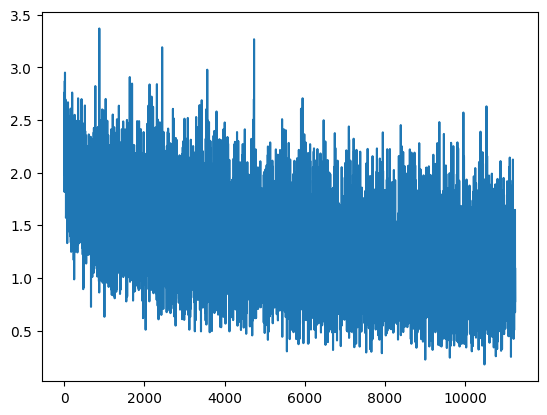

In [17]:
plt.plot(history['train_loss'])